# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Начнём с простого анализа данных - взглянем на график распределения наших наблюдений (фотографий с лицами людей) в разрезе целевого признака (возраста людей, изображенных на соответствующей фотографии).

Размер всего датасета: 7591
Пропущенные значения/дубли: 0
График распределения возраста в выборке:


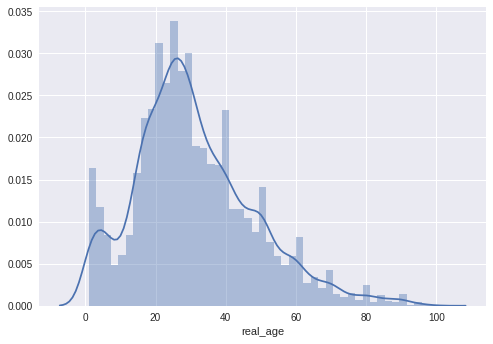

In [1]:
# Импорт библиотек, необходимых для анализа данных.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# В процессе  могу появиться некритичные ошибки. Скроем уведомления о них.
import warnings
warnings.filterwarnings("ignore")

# Вывод общей информации о датасете
labels = pd.read_csv('/datasets/faces/labels.csv')
print('Размер всего датасета:', labels.shape[0])
print('Пропущенные значения/дубли:', labels.isna().sum().sum() + labels.duplicated().sum().sum())

# Вывод графика распределения
print('График распределения возраста в выборке:')
plt.style.use("seaborn")
sns.distplot(labels['real_age'])
plt.show()

На графике распределения есть всплеск значений возраста около нуля. Убедимся, что подобное явление не является ошибочным - проверим несколько изображений, где возраст человека год или меньше. В остальном распределение имеет относительно нормальный вид.

Вывод фотографий понадобится сделать два раза, поэтому сделать это лучше внутри функции. Сама функция при этом возвращать созданный ImageGenerator не будет (создание обучающего и валидационного генератора по условиям задачи требуется сделать в отдельных функциях).

Наблюдений с нулевым или отрицательным значением в столбце real_age: 0
Изображений с людьми, возраст которых один год: 237 или 3.1 % от всех фотографий

Несколько примеров таких изображений:
Found 237 validated image filenames.


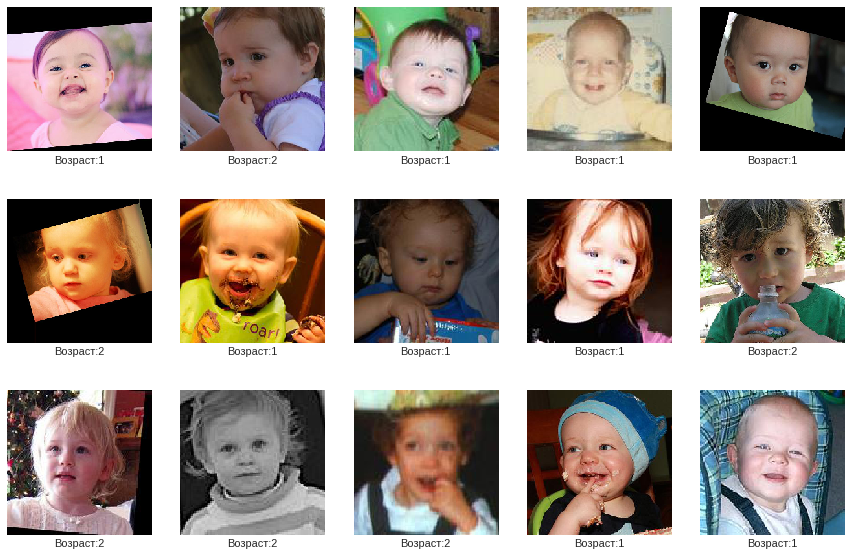

In [2]:
# Более детальное изучение околонулевых значений
print('Наблюдений с нулевым или отрицательным значением в столбце real_age:', labels.query('real_age < 1').count()[0])
labels_bottom = labels.query('real_age <= 2')
print('Изображений с людьми, возраст которых один год:', labels_bottom.count()[0],
     'или', ((labels_bottom.count()[0] / labels.count()[0])*100).round(1), '% от всех фотографий')
print('')
print('Несколько примеров таких изображений:')

def multiple_imgshow(data):
    # Подготовка датасета для вывода изображения
    datagen = ImageDataGenerator(rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
    features, target = next(datagen_flow)
    
    # Вывод изображения
    fig=plt.figure(figsize=(15, 10))
    columns = 5
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(features[i])
        plt.xlabel('Возраст:' + str(target[i]))
    plt.show()

# Применение функции для датасета с возрастом людей 1 год.
multiple_imgshow(labels_bottom)

Выглядит убедительно, технической ошибки дейтсвительно нет - целевой признак соответствует изображениям. Просто в выборке относительно много фотографий годовалых детей.

Проверим всё ли в порядке с основной выборкой.

Примеры фотографий и их целевых признаков
Found 7591 validated image filenames.


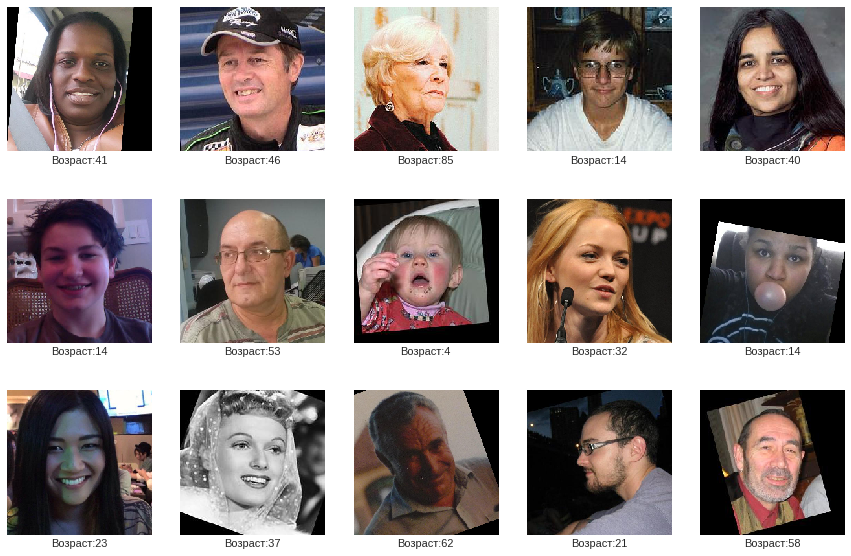

In [3]:
print('Примеры фотографий и их целевых признаков')
multiple_imgshow(labels)

С основной выборкой тоже всё в порядке, соответствие изображений и целевых признаков выглядит адекватным. Можем приступать к обучению модели.

## Обучение модели

С целью оптимизации скорости выполнения кода обучение модели проводилось на отдельном сервере с мощными GPU. В ноутбуке отобразим код-архитектуру модели, а также результат обучения.

Для правильной работы вычислительного сервера потребовалось соблюсти некоторые требования:
 - Импортировать необходимые для обучения модели библиотеки.
 - Подготовить функции загрузки обучающей и валидационной выборки.
 - Создать функции конструирования и обучения модели.
 
Основные характеристики обучаемой нейронной сети:
 - Использовать будем ResNet50.
 - Функция потерь - MSE.
 - Оптимизатор - Adam.
 - Выходной слой будет использовать активацию ReLU.
 - Обучение будет происходить в течение 10 эпох с размером батча равным 32.

**Код, переданный на сервер:**

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        pd.read_csv(path + 'labels.csv'),
        path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        pd.read_csv(path + 'labels.csv'),
        path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, validation_data = test_data, batch_size=batch_size, 
              validation_steps=validation_steps, steps_per_epoch=steps_per_epoch,
              epochs=epochs, verbose=2) 
    return model

```

**Процесс обучения модели**

```

178/178 - 51s - loss: 243.2670 - mae: 11.0707 - val_loss: 689.7302 - val_mae: 21.3118
Epoch 2/10
178/178 - 41s - loss: 64.0830 - mae: 6.0401 - val_loss: 663.3698 - val_mae: 20.7691
Epoch 3/10
178/178 - 42s - loss: 30.4317 - mae: 4.2119 - val_loss: 292.1001 - val_mae: 12.6259
Epoch 4/10
178/178 - 42s - loss: 19.0044 - mae: 3.3705 - val_loss: 131.8650 - val_mae: 9.0133
Epoch 5/10
178/178 - 41s - loss: 14.4979 - mae: 2.9227 - val_loss: 88.2866 - val_mae: 7.2955
Epoch 6/10
178/178 - 41s - loss: 11.5418 - mae: 2.5941 - val_loss: 76.7234 - val_mae: 6.8801
Epoch 7/10
178/178 - 41s - loss: 10.1056 - mae: 2.4524 - val_loss: 64.8181 - val_mae: 6.1616
Epoch 8/10
178/178 - 41s - loss: 9.1268 - mae: 2.3276 - val_loss: 66.5906 - val_mae: 6.1341
Epoch 9/10
178/178 - 42s - loss: 8.6380 - mae: 2.2392 - val_loss: 68.2988 - val_mae: 6.3345
Epoch 10/10
178/178 - 41s - loss: 8.0628 - mae: 2.1165 - val_loss: 70.2369 - val_mae: 6.4853

```

## Анализ обученной модели

Первое, что бросается в глаза - необходимый порог MAE < 8 был успешно преодолён. Изучим процесс и результаты обучения более детально на графике, попробуем определить потенциальные зоны улучшения качества и общей эффективности модели.

Функцию потерь (MSE) путём извлечения корня преобразуем в более близкий к конечной метрике (MAE) показатель. При изучении динамики улучшения качества, первую эпоху будем сравнивать с констатным предсказанием в виде медианного значения целевого признака.

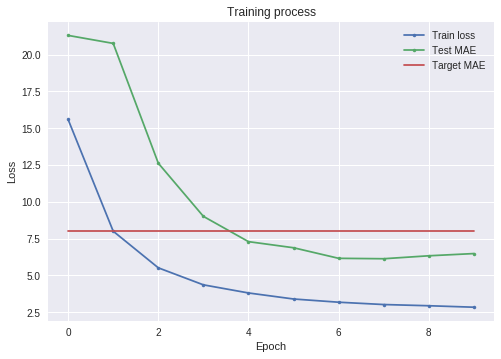

In [6]:
# Зафиксируем результаты обучения
loss = [243.2670, 64.0830, 30.4317, 19.0044, 14.4979, 11.5418, 10.1056, 9.1268, 8.6380, 8.0628]
val_mae = [21.3118, 20.7691, 12.6259, 9.0133, 7.2955, 6.8801, 6.1616, 6.1341, 6.3345, 6.4853]
loss_corrected = np.array(loss)**0.5

# Выведем их на линейном графике
plt.plot(loss_corrected, marker='.',)
plt.plot(val_mae, marker='.',)
plt.plot(np.repeat(8, 10))
plt.title('Training process')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test MAE', 'Target MAE'], loc='upper right')
plt.show()

In [1]:
# Импорт библиотек, необходимых для анализа данных.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Зафиксируем результаты обучения
loss = [243.2670, 64.0830, 30.4317, 19.0044, 14.4979, 11.5418, 10.1056, 9.1268, 8.6380, 8.0628]
val_mae = [21.3118, 20.7691, 12.6259, 9.0133, 7.2955, 6.8801, 6.1616, 6.1341, 6.3345, 6.4853]
loss_corrected = np.array(loss)**0.5


# Создаём DataFrame с прогрессом обучения
train_progress = pd.DataFrame({'Epoch': range(1,11), 'Loss': np.nan, 'MAE': np.nan})

for i in range(1, 10):
    # Первые улучшения качества нейросети будем сравнивать с константным предсказанием.
    train_progress['Loss'][0] = 1 - (loss_corrected[0] / labels['real_age'].median())
    train_progress['MAE'][0] = 1 - (val_mae[0] / labels['real_age'].median())
    # Остальные будем сравнивать с предыдущим значением Loss и Mae
    train_progress['Loss'][i] = 1 - (loss_corrected[i] / loss_corrected[i - 1])
    train_progress['MAE'][i] = 1 - (val_mae[i] / val_mae[i - 1])

# Создадим специальный датафрейм для построения barplot. 
barplot_table = train_progress.groupby(['Epoch']).sum().unstack(level=0).reset_index()
barplot_table.columns = ['Metric', 'Epoch', 'Percentage']
barplot_table['Percentage'] = (barplot_table['Percentage'] * 100).round(1)

# Изобразим всё это на графике. Задаём общий стиль, размеры графика, шрифтов...
plt.style.use("seaborn")
plt.figure(figsize=(15, 9))
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Изменение функции потерь и метрики по сравнению с предыдущей эпохой', fontsize=16)
plt.ylabel('ylabel', fontsize=15)
plt.xlabel('xlabel', fontsize=14)
#...передаём данные, по которым будет построен график и выведена легенда...
ax = sns.barplot(data = barplot_table, x = 'Epoch', y = 'Percentage', hue = 'Metric')
plt.legend(fontsize=13)
#... добавляем отображение процентов над столбцами и отрисовываем график.
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 1, '{:1.1%}'.format(height/100),
            ha="center", fontsize=13, weight='bold')
    p.set_width(0.4)
plt.show()

# Перейдём к построению итоговой таблицы. 
print('')
print('Итоговая таблица c приростами функции потерь и MAE по эпохам:')
# Сбросим индексы датафрейма...
train_progress.set_index('Epoch', inplace = True)
# ...добавим немного стиля...
train_progress = train_progress.style\
.applymap(lambda x: 'color : red' if x < 0 else '')\
.applymap(lambda x: 'color : green' if x > 0.1 else '')\
.applymap(lambda x: 'font-weight: bold' if x > 0.25 else '')\
.set_properties(**{'width': '150px', "font-size" : '150%'})\
.format({'MAE': '{:.1%}', 'Loss' : '{:.1%}'})
# ...и выведем полученную таблицу.
display(train_progress)

NameError: name 'labels' is not defined

### Интерпретация результатов и итоговые выводы.

Начнём с очевидных вещей - обученная нейронная сеть уже после первой эпохи показала точность на 26 % выше, чем константная модель. **Целесообразность использования модели не вызывает сомнений**, особенно с учётом относительно **высокой скорости обучения** (примерно 43 секунды для одной эпохи, или менее 8 минут на весь процесс обучения).

Заданное условием задачи качество (MAE < 8) было преодолено на второй эпохе для обучающей выборки, и на пятой эпохе для тестовой выборке. **Итоговое качество: MAE ≈ 6.4.** Это означает, что модель ошибается в возрасте человека в среднем на 6 лет. Для целей определения возрастной группы и контроля кассиров при продаже алкоголя - это допустимый разброс значений.

Исходя из анализа процесса обучения, полученное качество нейронной сети - потенциально не самый высокий результат, ведь функция потерь улучшалась на протяжении всех десяти эпох, снизились лишь темпы его улучшения. Кстати о темпах - на начальных эпохах функция потерь демонстрировала высокую скорость улучшения (по 30-50 % за эпоху), тогда как результат на валидации не так хорошо коррелировал с успехами в минимизации Loss (в конце даже valid MAE стал ухудшаться) - это может говорить о **возможном переобучении модели.**  Потенциальным решением этой проблемы и способом повышения качества может стать "замедление скорости обучения" - например, низкий learning rate оптимизатора, увеличение слоёв или аугментация параметров.